In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar placement
from scipy.sparse import issparse, diags # To construct rate matrix
import sys; sys.path.insert(0,"../"); import PyGT # Will be replaced by pip installation

## Load in matrix and vectors selecting $\mathcal{A,B}$ regions using the KTN format

KTN (Kinetic Transition Network) format requires two files:
- `min.data` columns :  $E,\,2S/{\rm k_B},\,D,\,I_x,\,I_y,\,I_z$
- `ts.data`  columns    :  $E,\,2S/{\rm k_B},\,D,\,f,\,i,\,I_x,\,I_y,\,I_z$

where 
- $E$ = Energy
- $S$ = Entropy
- $D$ = Degeneracy
- $I_x$ = $x$-moment of intertia
- $f,i$ = final,initial state indicies

Some technical details:
- `load_ktn()` function looks for files `[min,ts].data` to build KTN, pruning isolated nodes, giving a new node indexing
- `load_ktn_AB()` function looks for files `min.[A,B]` which use the same indicies as the data file
- `retained` is a vector that maps from the unpruned to pruned indexing convention, allowing `min.[A,B]` to be read
- Note that `A_vec, B_vec` can clearly be determined without using `load_ktn_AB()` or `retained`

## For this example we are loading in a 32 state network:

<img src="32state.png" alt="Example KTN" width="400"/>


In [2]:
data_path = "../KTN_data/32state"
temp = 0.5
beta = 1./temp

B, K, tau, N, u, s, Emin, retained = PyGT.io.load_ktn(path=data_path,beta=beta,screen=True)

F = u - s/beta # free energy

pi = np.exp(-beta * F) / np.exp(-beta * F).sum() # stationary distribution

# K has no diagonal entries
if issparse(K):
    Q = K - diags(1.0/tau)
else:
    Q = K - np.diag(1.0/tau)

A_vec, B_vec = PyGT.io.load_ktn_AB(data_path,retained)
I_vec = ~(A_vec+B_vec)
print(f'States in A,I,B: {A_vec.sum(),I_vec.sum(),B_vec.sum()}')

communities = PyGT.io.read_communities(data_path+"/communities.dat",retained,screen=True)
print('\nCommunities file identifies %d macrostates' % len(communities.keys()))


	Connected Clusters: 1, of which 95% have <= 32 states
	Retaining largest cluster with 32 nodes

States in A,I,B: (8, 16, 8)
Community 0: 8
Community 1: 8
Community 2: 8
Community 3: 8

Communities file identifies 4 macrostates


# Remove a set of nodes in $\mathcal{I}$ using graph transformation

- We remove all nodes in $\mathcal{I} = (\mathcal{A}\cup\mathcal{B})^\mathsf{c}$ above the 10th percentile in free energy
- See documentation of ` PyGT.tools.choose_nodes_to_remove() ` for other options

In [3]:

rm_vec = PyGT.tools.choose_nodes_to_remove(rm_region=I_vec,
                                              pi=pi,
                                              tau=tau,
                                              style="free_energy",
                                              percent_retained=10
                                             )


gt_B, gt_tau, gt_K = PyGT.GT.blockGT(rm_vec,B,tau,block=10,rates=True,screen=True)



GT BECAME DENSE AT N=32, density=0.136719
GT done in 0.042 seconds with 0 floating point corrections


## Find communitity MFPT matrix via full MFPT calculation or metastability approx
Reduced Boltzmann is the same in both cases

In [4]:
#exact weighted-MFPT matrix
c_pi, c_tauM = PyGT.mfpt.community_MFPT_matrix(communities,B,tau,pi,MS_approx=False,screen=True)
#approximate weighted-MFPT matrix
c_pi, c_tauM_approx = PyGT.mfpt.community_MFPT_matrix(communities,B,tau,pi,MS_approx=True,screen=True)
#stationary distribution of macrostates
print(c_pi)
print(c_tauM)
#alternatively, we can compute the weighted-MFPTs from a pre-specified full inter-microstate MFPT matrix
ktn = PyGT.tools.Analyze_KTN(data_path, K=Q.todense(), pi=pi, commdata='communities.dat')
c_tauM_ktn = ktn.get_intercommunity_weighted_MFPTs(tauM)
print(c_tauM_ktn)


[0.38806874 0.14276251 0.25619212 0.21297664]
[[    0.          3899.54127059  5653.48224732  7200.74232227]
 [ 5877.59783142     0.          8471.75235831  5002.54025432]
 [ 7770.59652476  8610.81007492     0.          6624.96898056]
 [11155.95040591  6979.69177712  8463.06278675     0.        ]]


NameError: name 'tauM' is not defined

## Plot exact, approximate and ratio of MFPT matrices
Diagonal entries will be set to zero in application, but here we set diagonal terms to unity to avoid errors when taking ratio.

In [ ]:
c_tauM += np.eye(c_pi.size) - np.diag(c_tauM) # i.e. remove diagonal and replace with 1
c_tauM_approx += np.eye(c_pi.size) - np.diag(c_tauM_approx) # i.e. remove diagonal and replace with 1

fig,axs = plt.subplots(1,3,figsize=(12,4),dpi=120)

for i,Mt in enumerate([
    [c_tauM,r"MFPT matrix $\mathcal{T}$ [Time]"],
    [c_tauM_approx,r"MFPT matrix $\mathcal{T}_{\rm approx}$ [Time]"],
    [c_tauM_approx/c_tauM,r"Ratio $\mathcal{T}_{\rm approx}\,/\,\mathcal{T}$"]]):
    axs[i].set_title(Mt[1],pad=-4.0)
    
    im = axs[i].matshow(Mt[0])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    plt.colorbar(im, cax=cax)
plt.tight_layout()


## First passage time distribution between $\mathcal{A}$ and $\mathcal{B}$

tau A<-B : mean: 4.269867111336783 , std: 2.145910952844471
tau B<-A : mean: 4.604933817537865 , std: 2.1524119768649936


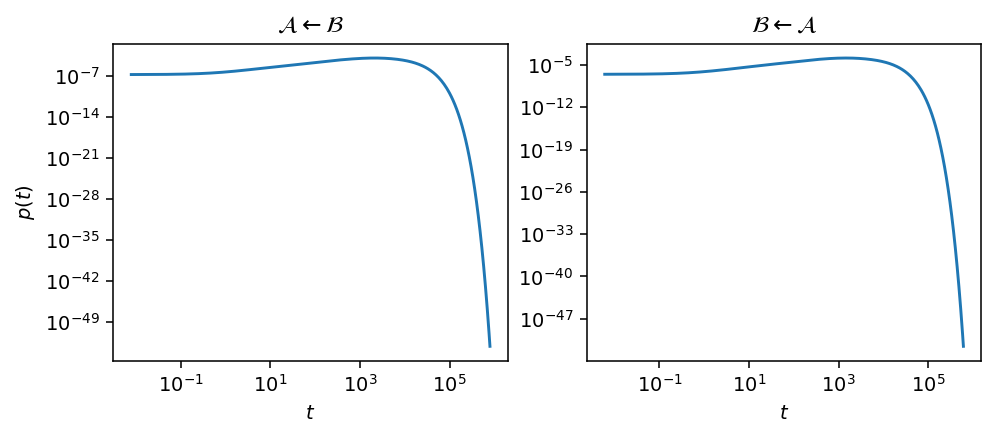

In [5]:

moments, pt = PyGT.stats.compute_passage_stats(A_vec,B_vec,pi,Q,dopdf=True,rt=np.logspace(-6,2,400))

fig,axs = plt.subplots(1,2,figsize=(8,3),dpi=140)

axs[0].loglog(pt[:,0],pt[:,1]/moments[0])
axs[0].set_title(r"$\mathcal{A}\leftarrow\mathcal{B}$")
axs[0].set_ylabel(r"$p(t)$")
axs[0].set_xlabel(r"$t$")
axs[1].loglog(pt[:,2],pt[:,3]/moments[2])
axs[1].set_title(r"$\mathcal{B}\leftarrow\mathcal{A}$")
axs[1].set_xlabel(r"$t$")

print("tau A<-B : mean:",tau[0],", std:",np.sqrt(tau[1]))
print("tau B<-A : mean:",tau[2],", std:",np.sqrt(tau[3]))



# Spectral Regrouping

In [3]:
A_rho = (pi * A_vec) / pi[A_vec].sum()
B_rho = (pi * B_vec) / pi[B_vec].sum()

rQ, rpi, rA_rho = PyGT.spectral.reduce(communities,pi, Q, initial_dist=A_rho)